In [1]:
"""pca for fault detection and fault diagnosis"""

from pylab import *
from scipy.linalg import eigh
from scipy.stats import f, chi2, zscore
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  #显示中文
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号


###############################################################################
class PCA_FaultDection():
    def __init__(self, cumper=0.9, signifi=0.95):
        self.cumper = cumper
        self.signifi = signifi
        self.model = None

    def normalize(self, X, Y):
        # 用训练数据的标准差和均值对测试数据标准化
        X_mu = np.mean(X, axis=0).reshape((1, X.shape[1]))
        X_std = np.std(X, axis=0).reshape((1, X.shape[1]))
        Xs = (X-X_mu)/X_std
        mu_array = np.ones((Y.shape[0], 1)) * X_mu
        st_array = np.ones((Y.shape[0], 1)) * X_std
        Ys = (Y - mu_array) / st_array
        return Xs, Ys

      
    def pc_number(self,X):
        U, S, V = np.linalg.svd(X)
        if S.shape[0] == 1:
            i = 1
        else:
            i = 0
            var = 0
            while var < self.cumper*sum(S*S):
                var = var+S[i]*S[i]
                i = i + 1
            return i

       
    def train(self, X):
        row=X.shape[0]
        
        #主元数选择
        num_pc=self.pc_number(X)
        cov = (X.T @ X) /(len(X)-1)
        U, S, V = np.linalg.svd(cov)
        P=U[:,:num_pc]
        T = X @ P  
        lambdas=np.diag(S[:num_pc])
  
   

        # 计算控制限
#         self.model['SPE_limit'], self.model['T2_limit'] = self.cal_controllimit(self.model)
        T2_limit = num_pc* (row - 1) / (row- num_pc ) \
            * f.ppf(self.signifi, num_pc, row- num_pc)
        
        # 计算SPE控制限
        SPE = np.square(X).sum(axis=1) - np.square(T).sum(axis=1)
        m, s = np.mean(SPE), np.var(SPE)
        g, h = s / (2 * m), 2 * np.square(m) / s
        SPE_limit = g * chi2.ppf(self.signifi, h)
        
        # 存储训练模型
        self.model = {
            'P': P,
            'lambdas':lambdas,
            'num_pc':num_pc,
            'row': row,
            'SPE_limit': SPE_limit,
            'T2_limit': T2_limit
            
        }

    def test(self, testdata):
        # 计算T2\、SPE统计量
        lambdas = self.model['lambdas']
        P=self.model['P']
        H=np.identity(testdata.shape[1])-P@P.T
        T2=[]
        SPE=[]
        for i in range(testdata.shape[0]):
            t1 = testdata[i,:] @ P 
            t2 = testdata[i,:] @ H 
            T2.append(t1@np.linalg.inv( self.model['lambdas'])@t1.T)
            SPE.append(t2@t2.T)

        # 报警值个数
        SPE_alarm = np.nonzero(SPE > self.model['SPE_limit'])
        T2_alarm = np.nonzero(T2 > self.model['T2_limit'])
        print('测试样本总数：%d\n' % testdata.shape[0])
        print('SPE统计量报警总数：%d\n' % len(SPE_alarm[0]))
        print('T2统计量报警总数：%d\n' % len(T2_alarm[0]))

        result = {
            'SPE': SPE,
            'T2': T2
        }

        return result
    
    def single_sample_con(self,x_test):#贡献图(reconstruction based contribution plot)
        m=   x_test.shape[1]
        for i in range(3):
            if i==0:       #Tc
                M1=(self.model['P']@(np.linalg.inv(self.model['lambdas'])**0.5)@self.model['P'].T)     
            else:         #Qx
                M1=np.identity(m)-self.model['P']@self.model['P'].T 
            con=[]
            for j in range(m):
                con += list(np.power(M1[j,:]@(x_test.T),2));
            if i==0:       #Tx
                Tx_con=con;
            else:         #Qx
                Qx_con=con;
                
        singlesample_con_result={
        'Tx_con': Tx_con,
        'Qx_con': Qx_con             
        }
        return singlesample_con_result
          
    def con_bar_vis(self, con_result,fea_names):
        mpl.rcParams['font.sans-serif'] = ['SimHei']
        Tx_con, Qx_con = con_result['Tx_con'], con_result['Qx_con']
        
        plt.figure(figsize=(9.6,6.4),dpi=600)
        ax1 = plt.subplot(2,1,1)
        ax1.tick_params(axis='x', labelsize=6)    # 设置x轴标签大小
        ax1.bar(x=range(len(Tx_con)),height=Tx_con,width=0.7,label='Tx_con变量贡献')
        ax1.legend(loc="right")  
        
        ax2= plt.subplot(2,1,2)
        ax2.tick_params(axis='x', labelsize=10, rotation=-15)    # 设置x轴标签大小
        ax2.bar(x=fea_names,height=Qx_con,width=0.9,label='Qx_con变量贡献')
        ax2.legend(loc="right") 
        
    def con_bar_vis(self, con_result):
        mpl.rcParams['font.sans-serif'] = ['SimHei']
        Tx_con, Qx_con = con_result['Tx_con'], con_result['Qx_con']
        
        plt.figure(figsize=(9.6,6.4),dpi=600)
        ax1 = plt.subplot(2,1,1)
        ax1.tick_params(axis='x', labelsize=6)    # 设置x轴标签大小
        ax1.bar(x=range(len(Tx_con)),height=Tx_con,width=0.7,label='Tx_con变量贡献')
        ax1.legend(loc="right")  
        
        ax2= plt.subplot(2,1,2)
        ax2.tick_params(axis='x', labelsize=10, rotation=-15)    # 设置x轴标签大小
        ax2.bar(x=range(len(Tx_con)),height=Qx_con,width=0.9,label='Qx_con变量贡献')
        ax2.legend(loc="right")   
    
    def single_sample_recon(self,x_test):#贡献图(reconstruction based contribution plot)
        m=   x_test.shape[1]
        for i in range(2):
            x_test=x_test.reshape(1,-1)          
            if i==0:       #Tc
                M1= self.model['P']@np.linalg.inv(self.model['lambdas'])@self.model['P'].T;
            else:         #Qx
                M1=np.identity(m)-self.model['P']@self.model['P'].T 
            Recon=[]
            for j in range(m):
                Recon+=list(np.power(M1[j,:]@(x_test.T),2)/M1[j,j])
            if i==0:       #Tc
                Tx_recon=Recon;
            else:         #Qx
                Qx_recon=Recon;
                
        singlesample_recon_result={
        'Tx_recon': Tx_recon,
        'Qx_recon': Qx_recon             
        }
        return singlesample_recon_result
    
    def multi_sample_recon(self,X_test):#贡献图(reconstruction based contribution plot)
        n=   X_test.shape[0]
        Tx_recon = []
        Qx_recon = []
        for i in range(n):
            singlesample_recon_result = self.single_sample_recon(X_test[i:i+1,:])
            Tx_recon.append(singlesample_recon_result['Tx_recon'])
            Qx_recon.append(singlesample_recon_result['Qx_recon'])
            
        multisample_recon_result={
        'Tx_recon': Tx_recon,
        'Qx_recon': Qx_recon             
        }
        return multisample_recon_result

    def recon_vis_headmap(self, recon_result):
        plt.figure(figsize=(9.6,6.4),dpi=200)
        ax1 = sns.heatmap(np.array(recon_result['Tx_recon']).T, cmap=sns.color_palette("RdBu_r", 50))
        ax1.set_xlabel('Samples')
        ax1.set_ylabel('Variables')
        
#         ax2 = sns.heatmap(np.array(recon_result['Qx_recon']).T, cmap=sns.color_palette("RdBu_r", 50))
#         ax2.set_xlabel('Samples')
#         ax2.set_ylabel('Variables')
    
  
    def visualization(self, model, testresult):
        mpl.rcParams['font.sans-serif'] = ['SimHei']
        SPE, T2 = testresult['SPE'], testresult['T2']
        SPE_limit, T2_limit = self.model['SPE_limit'], self.model['T2_limit']
        plt.figure(figsize=(9.6,6.4),dpi=600)
        ax1 = plt.subplot(2,1,1)
        ax1.axhline(y=T2_limit,ls="--",color="r",label='T2控制限')
        ax1.plot(T2,label='T2监测量')
        ax1.legend(loc="right")
        
        ax2= plt.subplot(2,1,2)
        ax2.plot(SPE,label='SPE监测量')
        ax2.axhline(y=SPE_limit,ls="--",color="r",label='SPE控制限')
        ax2.set_title('过程监控图')
        ax2.legend(loc="right")
        plt.show()
      
  
        
    def recon_bar_vis(self, recon_result,fea_names):
        mpl.rcParams['font.sans-serif'] = ['SimHei']
        Tx_recon, Qx_recon =recon_result['Tx_recon'], recon_result['Qx_recon']
        plt.figure(figsize=(9.6,6.4),dpi=600)
        ax1= plt.subplot(2,1,1)
        ax1.bar(x=range(len(Tx_recon)),height=Tx_recon,width=0.9,label='Tx_recon变量重构贡献')
        ax1.legend(loc="right")  
        ax2= plt.subplot(2,1,2)
        ax2.bar(x=fea_names,height=Qx_recon,width=0.9,label='Qx_recon变量重构贡献')
        ax2.tick_params(axis='x', labelsize=10, rotation=-15)    # 设置x轴标签大小
        ax2.legend(loc="right") 

        
    def recon_bar_vis(self, recon_result):
        mpl.rcParams['font.sans-serif'] = ['SimHei']
        Tx_recon, Qx_recon =recon_result['Tx_recon'], recon_result['Qx_recon']
        plt.figure(figsize=(9.6,6.4),dpi=600)
        ax1= plt.subplot(2,1,1)
        ax1.bar(x=range(len(Tx_recon)),height=Tx_recon,width=0.9,label='Tx_recon变量重构贡献')
        ax1.legend(loc="right")  
        ax2= plt.subplot(2,1,2)
        ax2.bar(x=range(len(Tx_recon)),height=Qx_recon,width=0.9,label='Qx_recon变量重构贡献')
        ax2.tick_params(axis='x', labelsize=10, rotation=-15)    # 设置x轴标签大小
        ax2.legend(loc="right") 
        
    def multi_sample_con(self,X_test):#贡献图(reconstruction based contribution plot)
        n=   X_test.shape[0]
        Tx_con = []
        Qx_con = []
        for i in range(n):
#             print(i)
            singlesample_con_result = self.single_sample_con(X_test[i:i+1,:])
            Tx_con.append(singlesample_con_result['Tx_con'])
            Qx_con.append(singlesample_con_result['Qx_con'])
        multisample_con_result={
        'Tx_con': Tx_con,
        'Qx_con': Qx_con             
        }
        return multisample_con_result
    
    def con_vis_headmap(self, con_result):
        plt.figure(figsize=(9.6,6.4),dpi=200)
        ax = sns.heatmap(np.array(con_result['Tx_con']).T, cmap=sns.color_palette("RdBu_r", 50))
#         sns.set()
#         ax = sns.heatmap(np.array(con_result['Qx_con']).T, cmap=sns.color_palette("RdBu_r", 50))
        ax.set_xlabel('Samples')
        ax.set_ylabel('Variables')

测试样本总数：960

SPE统计量报警总数：859

T2统计量报警总数：806



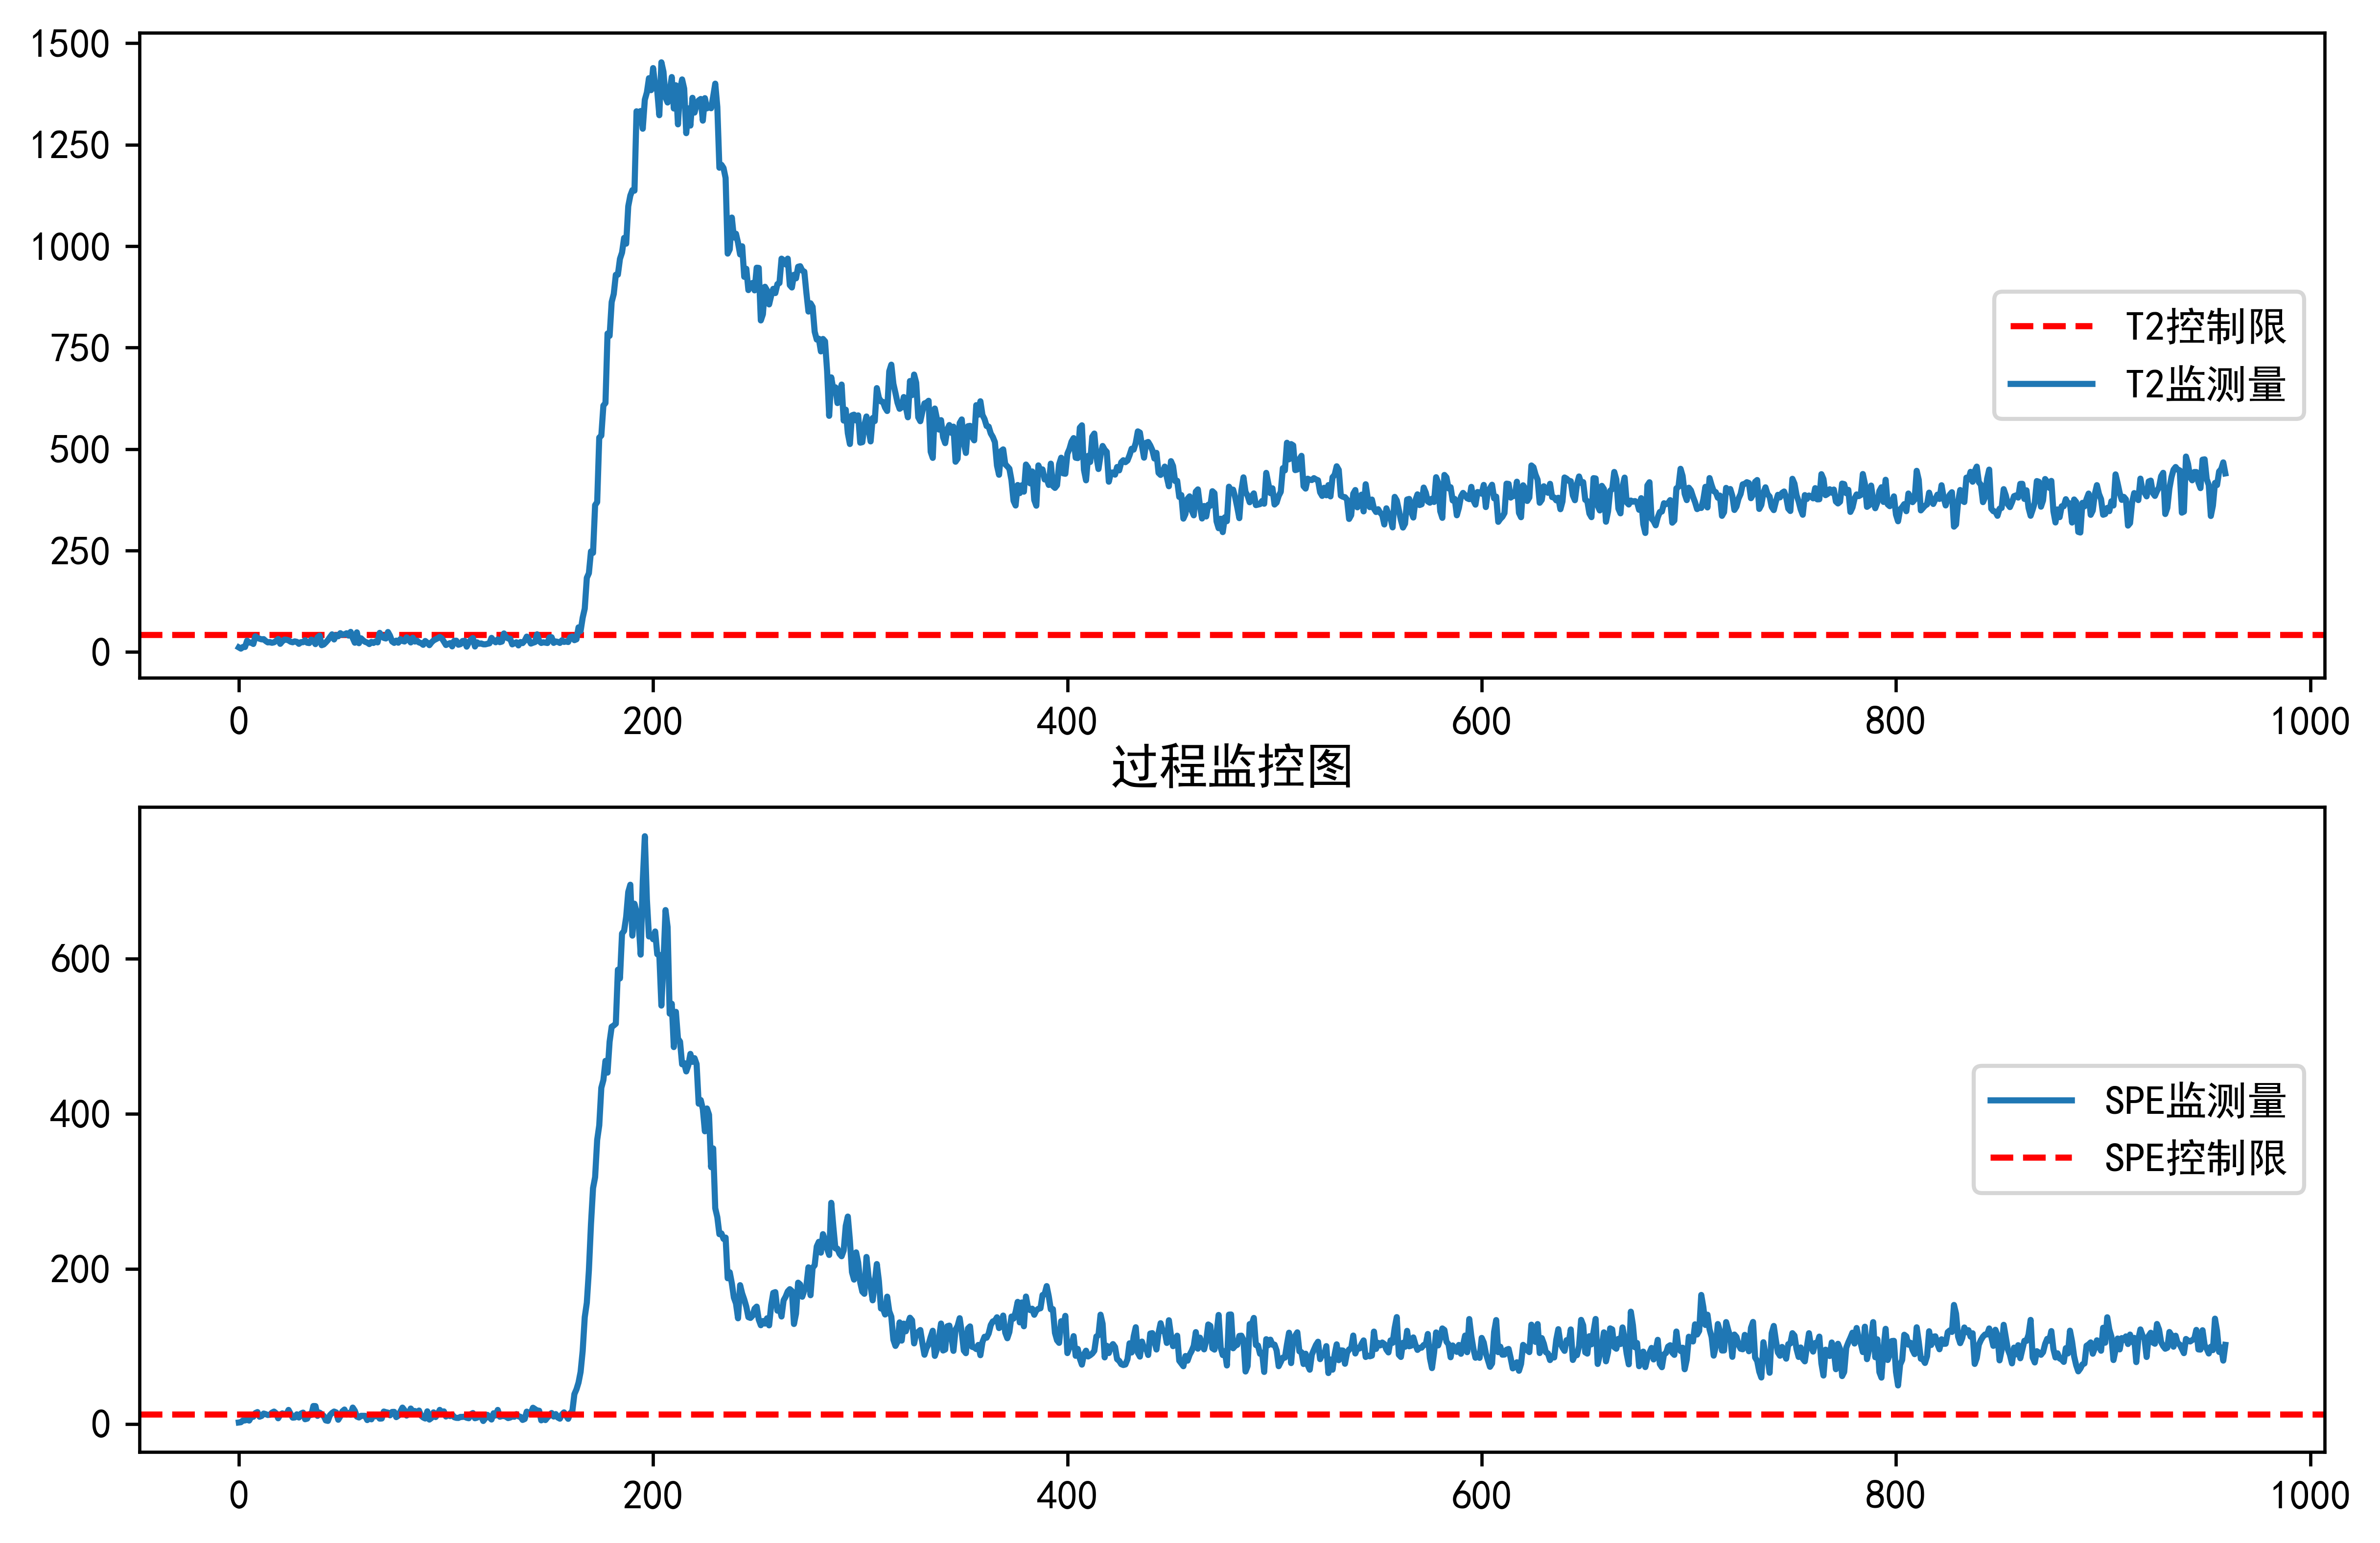

In [2]:
# from PCA_FaultDection import *
from scipy.io import loadmat

# 读取数据
path_train = './data/d00.mat'
path_test= './data/d01te.mat'
X_Train = loadmat(path_train)['d00']
X_test = loadmat(path_test)['d01te']
#初始化PCA模型参数
model = PCA_FaultDection(cumper=0.85, signifi=0.95)

#数据标准化（若是标准化过后的数据则无需这一步）
[X_Train,X_test] = model.normalize(X_Train, X_test)


#训练模型
model.train(X_Train)

#代入测试数据
testresult = model.test(X_test)

#检测结果可视化
model.visualization(model,testresult)




### 贡献图分析

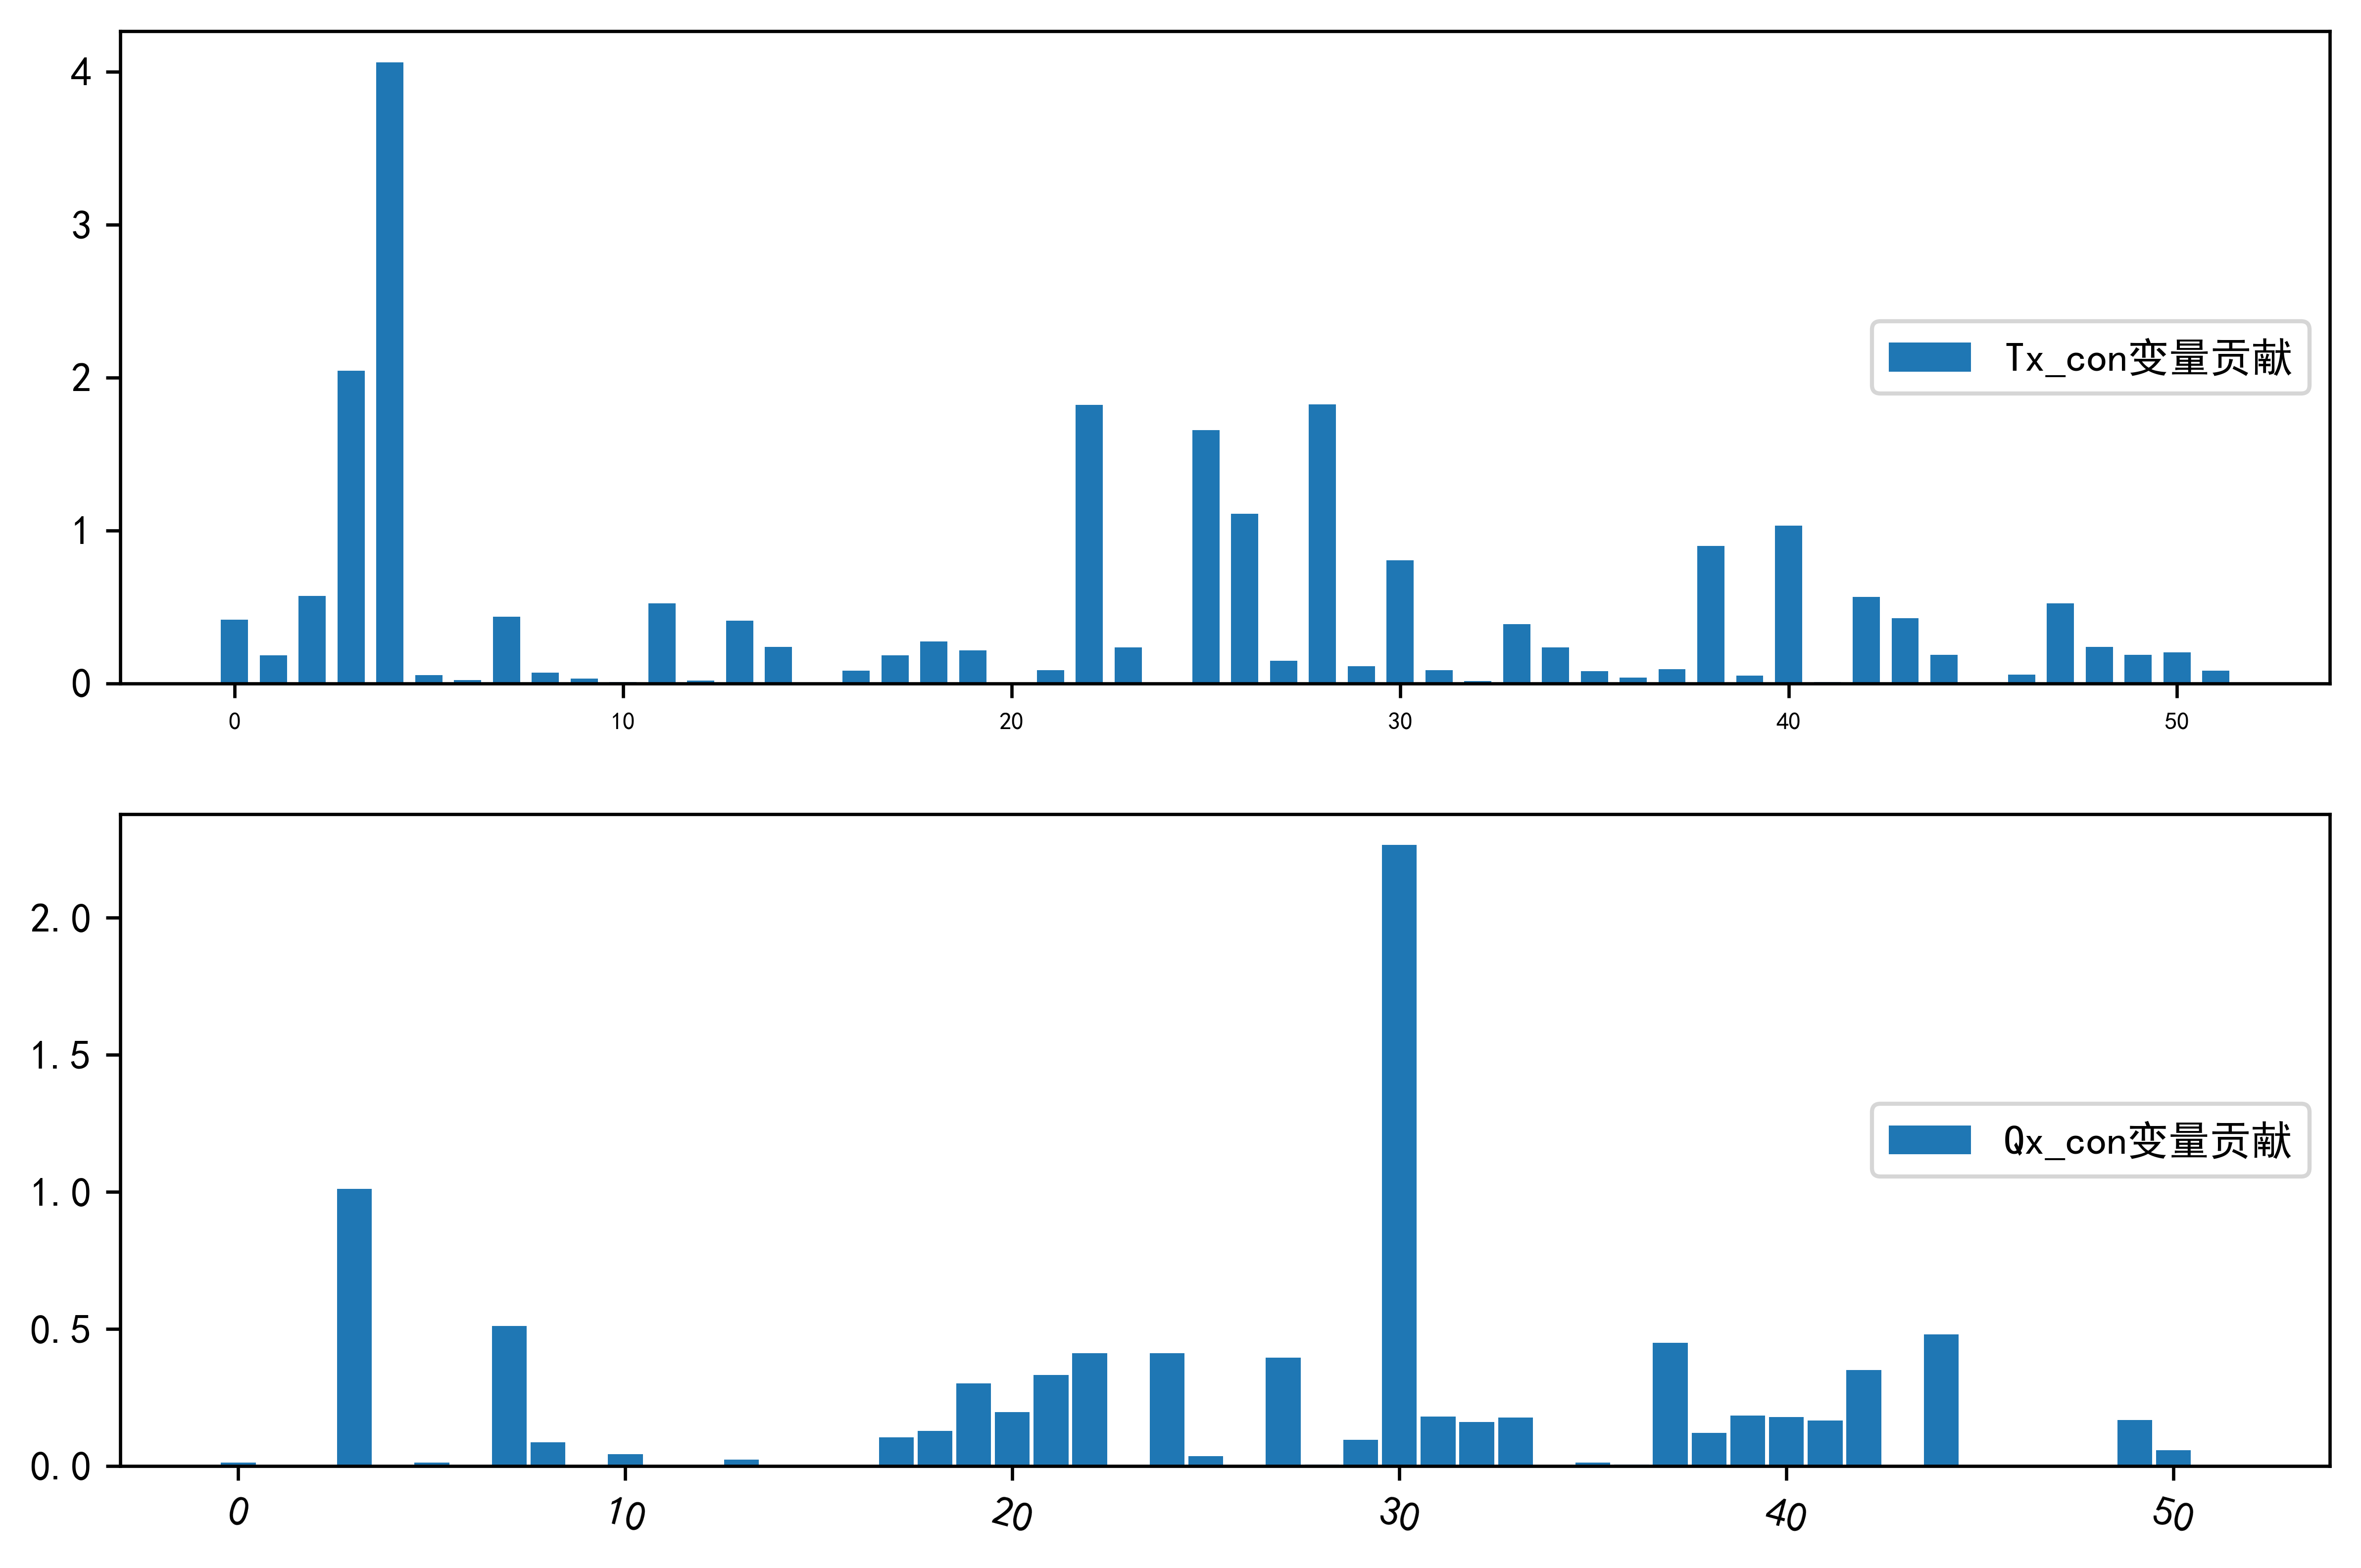

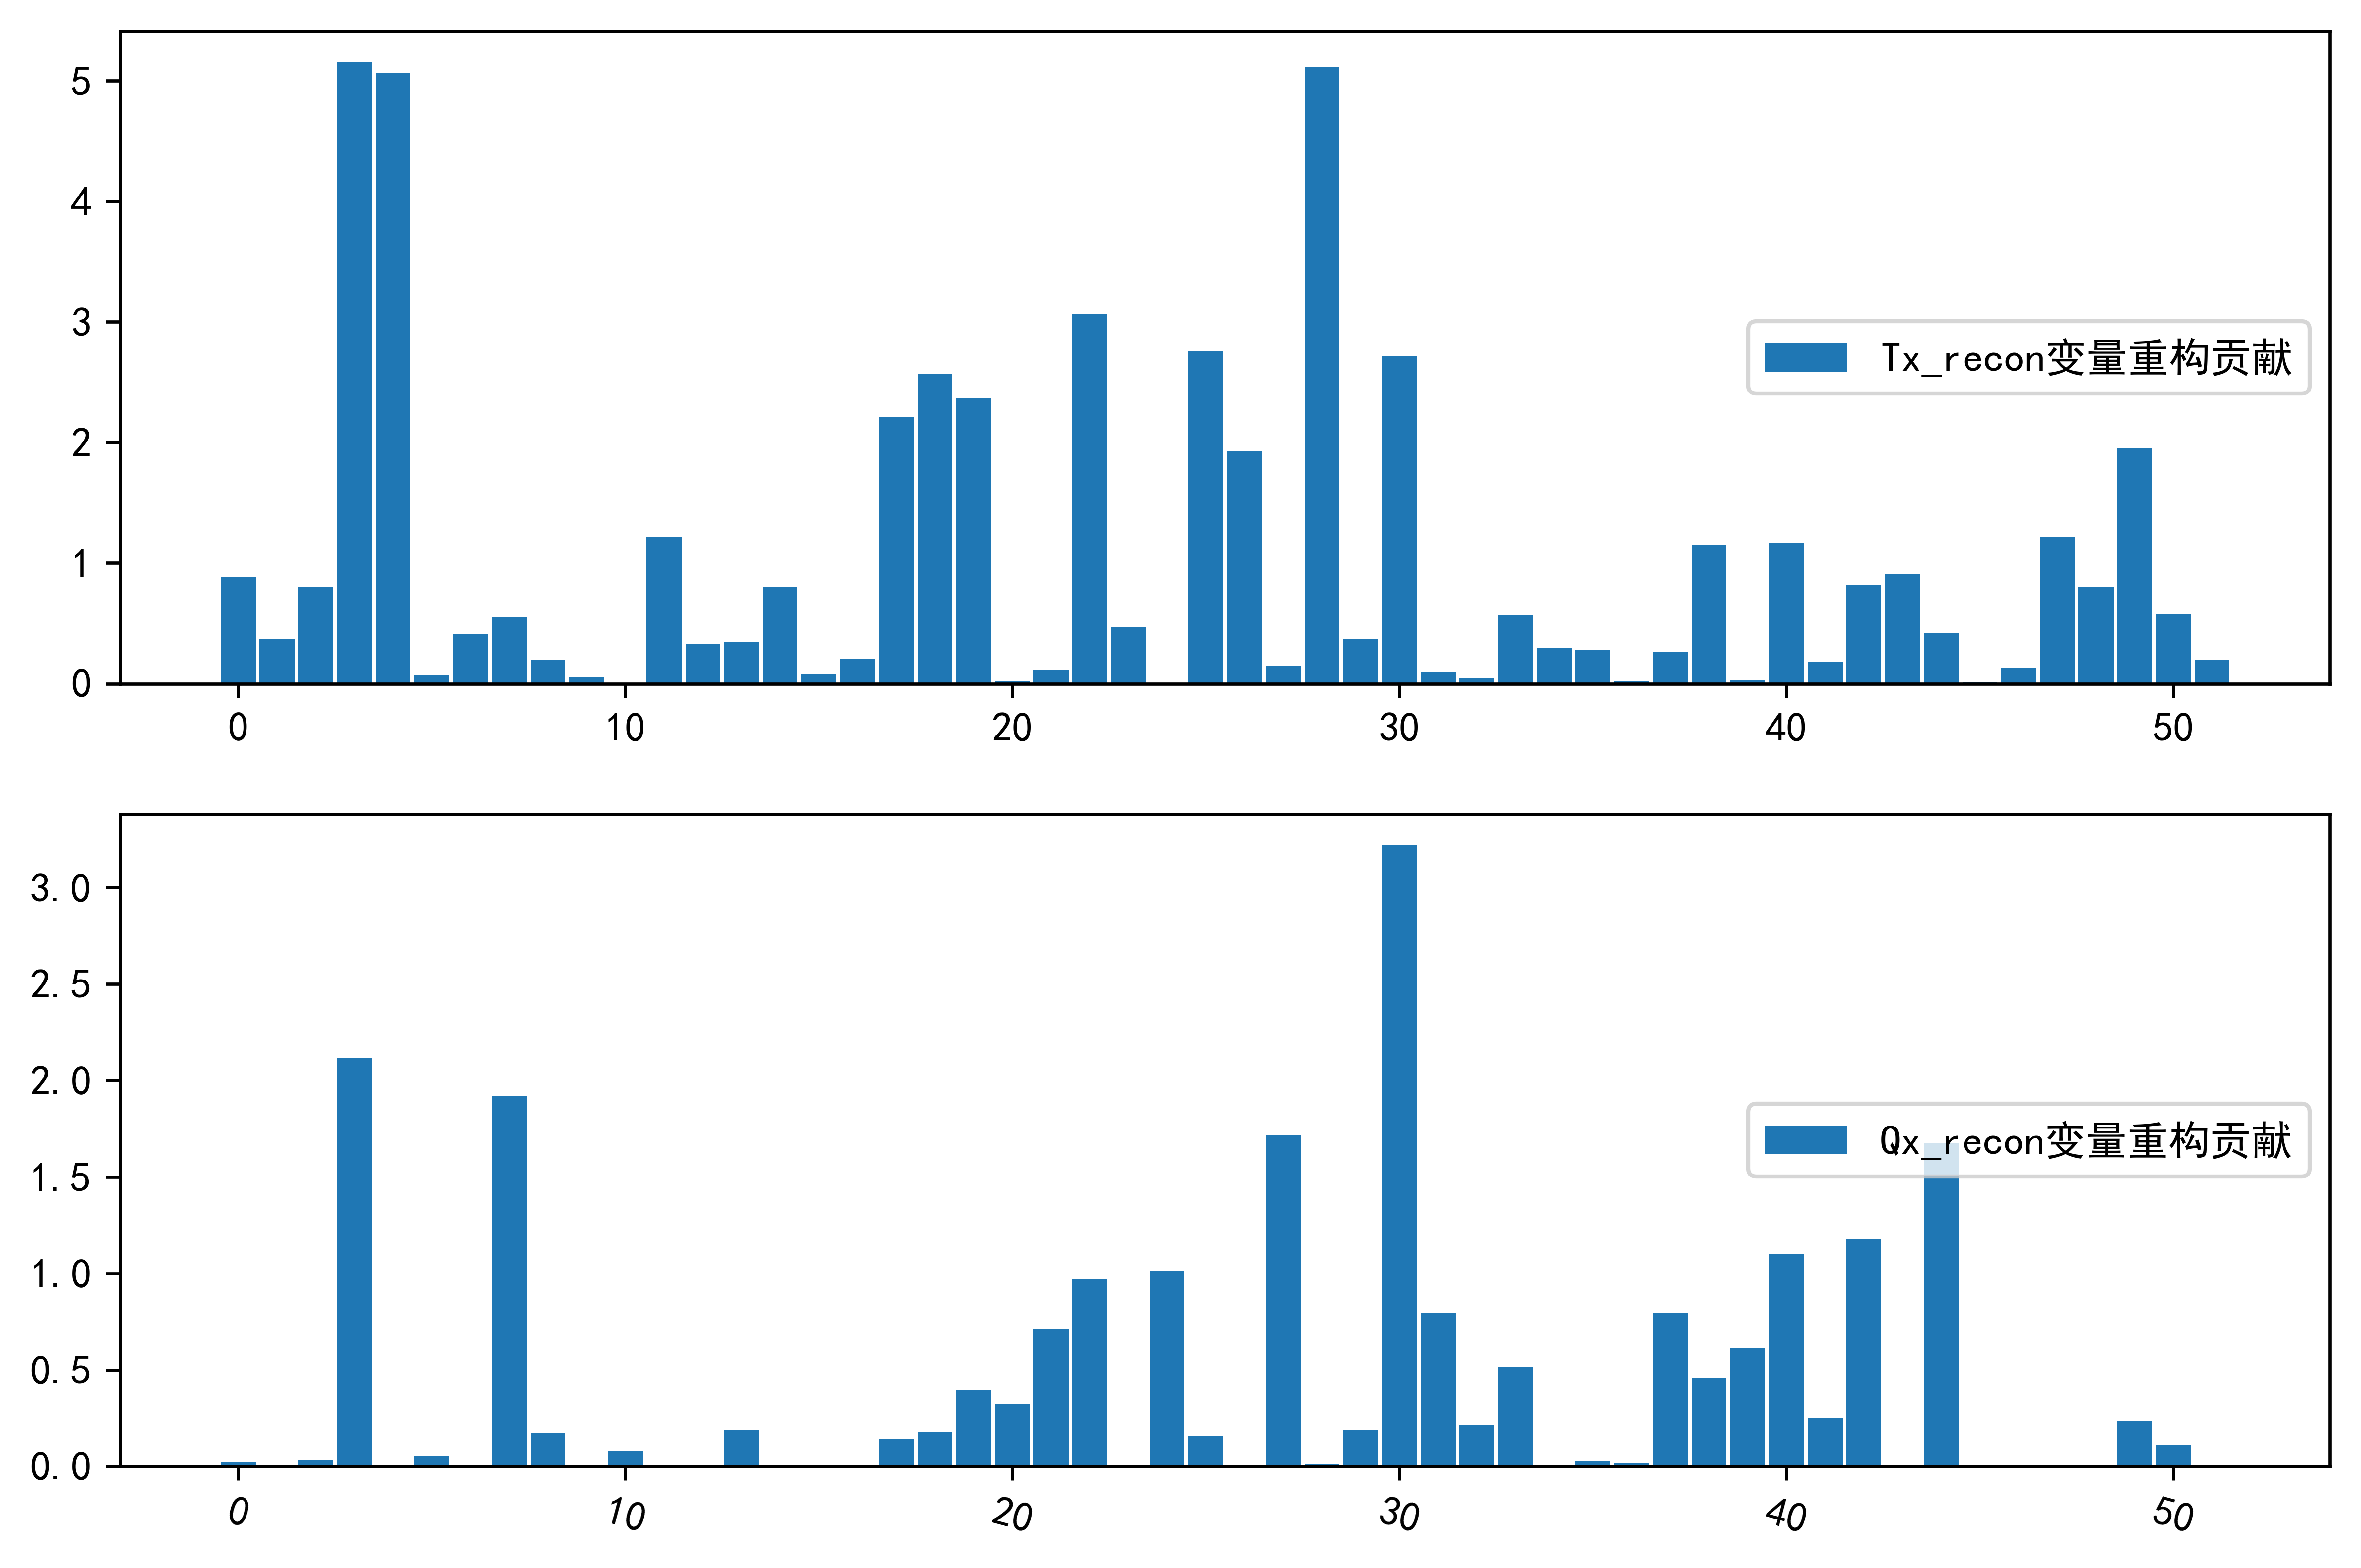

In [3]:
# 单样本 贡献图条状图可视化
single_con_result=model.single_sample_con(X_test[6:7]) # 实际取得是第七个样本，必须写成切片索引的方式 : idx:idx+1
model.con_bar_vis(single_con_result)


#单样本重构贡献图条状图可视化
single_recon_result=model.single_sample_recon(X_test[6:7])# 实际取得是第七个样本，必须写成切片索引的方式 : idx:idx+1
model.recon_bar_vis(single_recon_result)



### 热力图分析

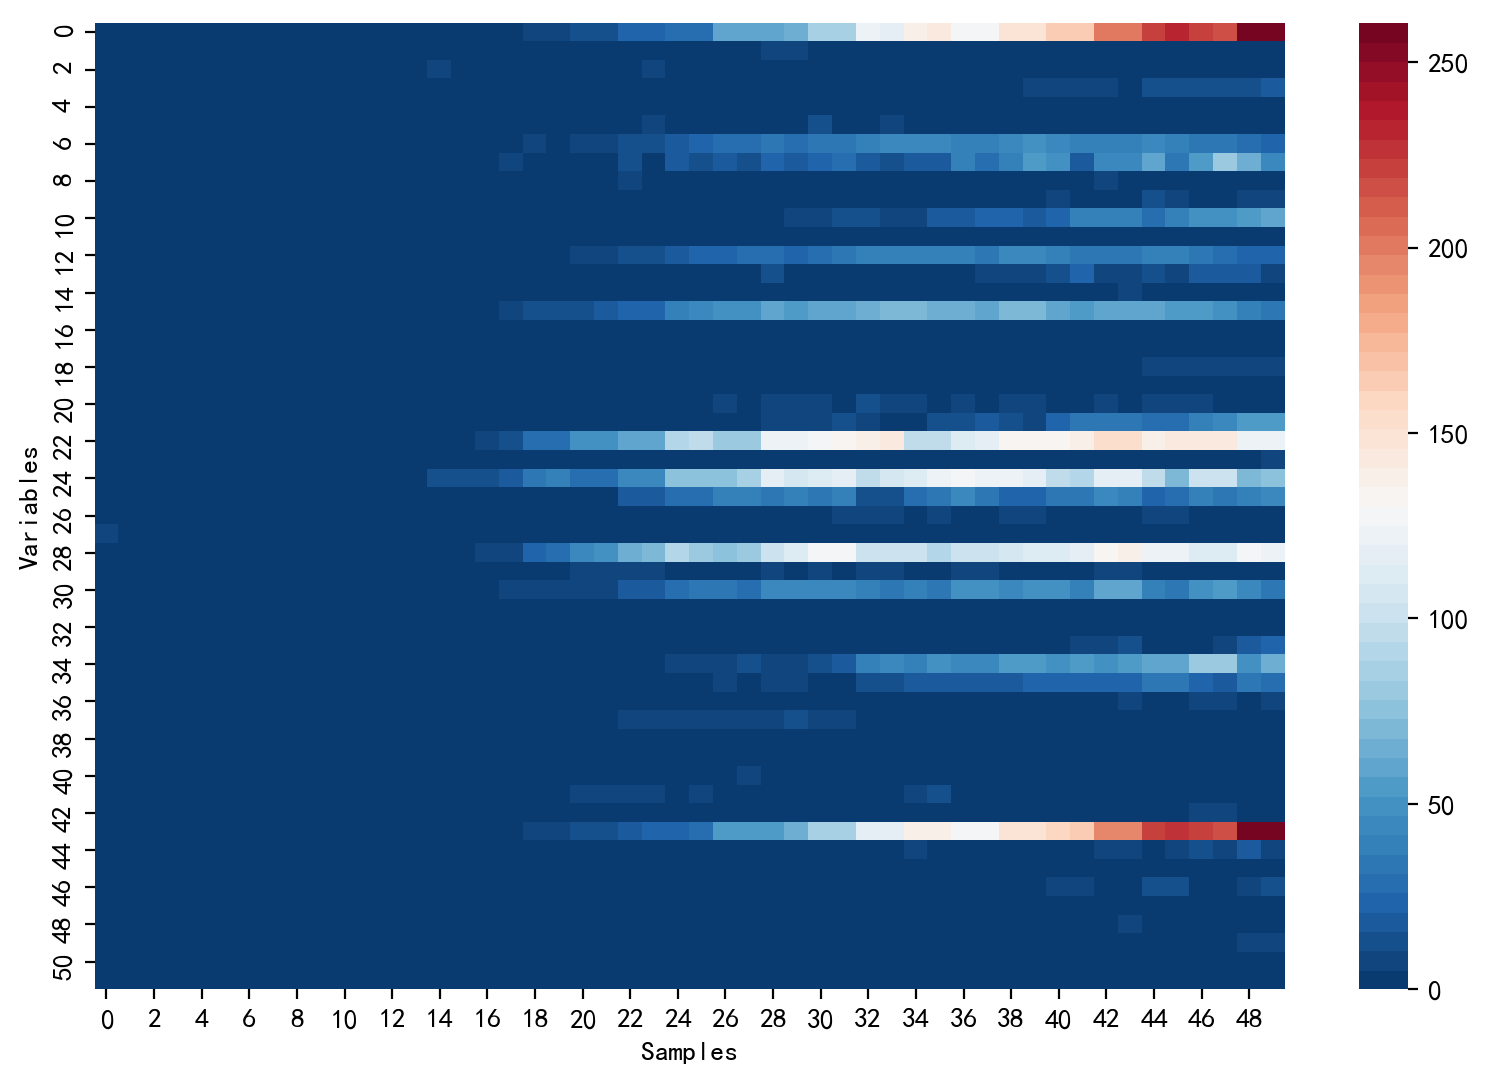

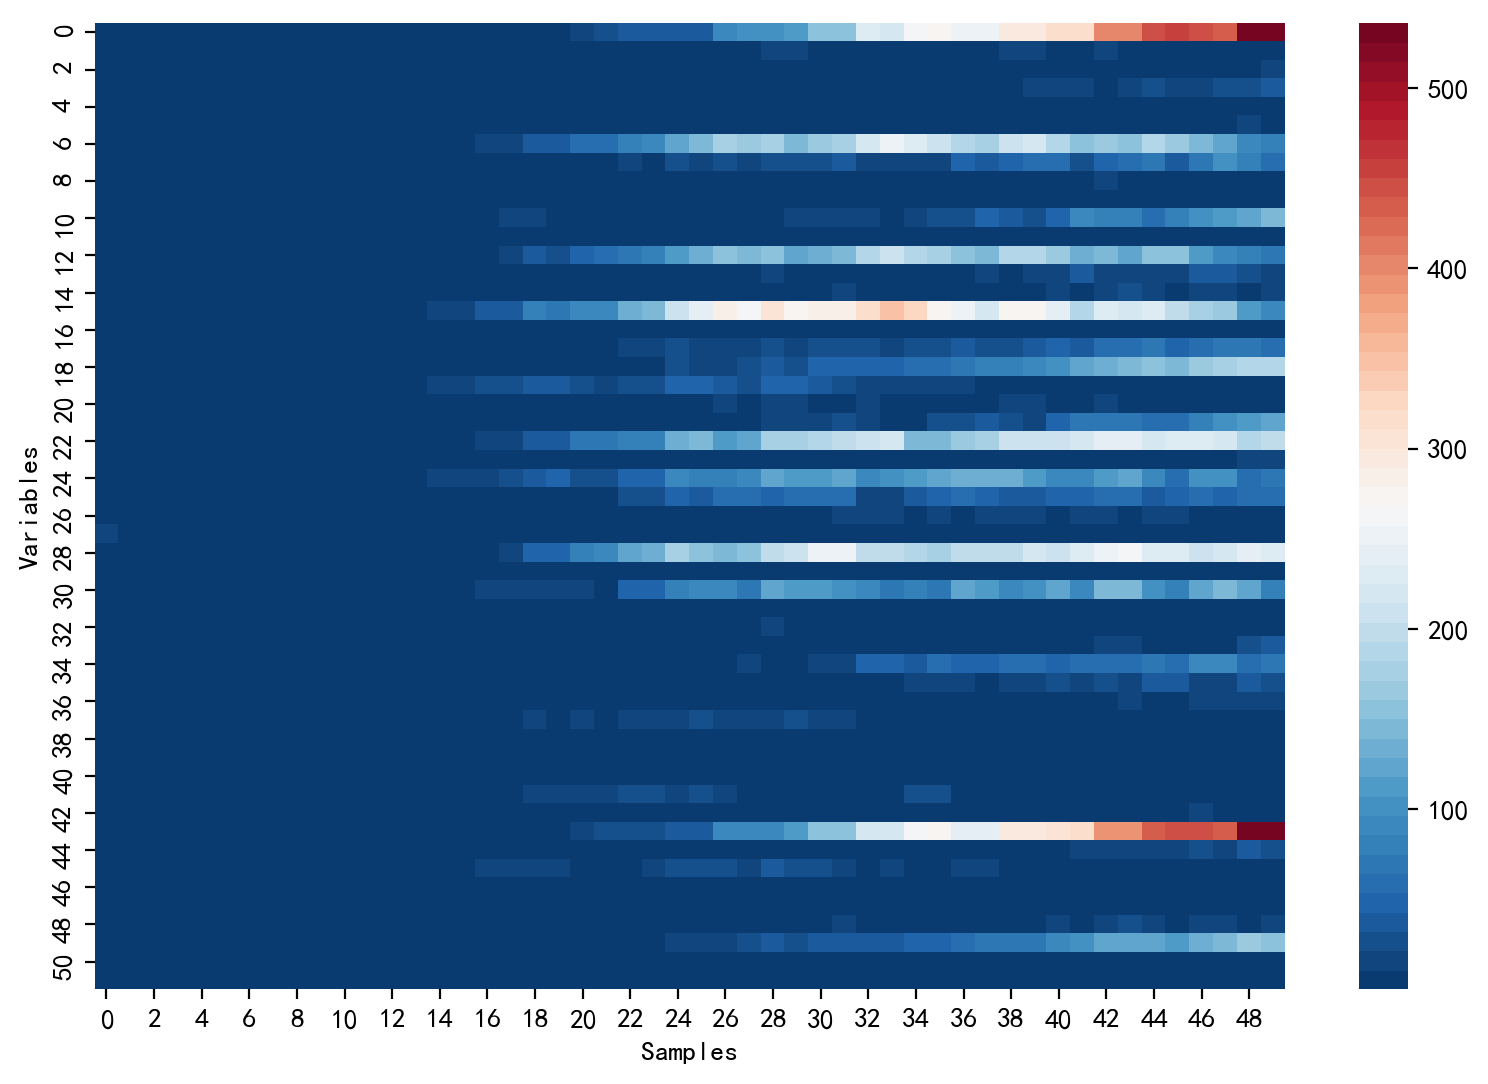

In [4]:
#多样本贡献图热力图可视化
multi_con_result=model.multi_sample_con(X_test[150:200])
model.con_vis_headmap(multi_con_result)

#多样本重构贡献图热力图可视化
multi_recon_result=model.multi_sample_recon(X_test[150:200])
model.recon_vis_headmap(multi_recon_result)